In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import itertools

from sklearn import preprocessing
from sklearn import svm, metrics, neural_network, linear_model, ensemble
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv('train.csv')

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


## VariableDefinition
survival: Survival 0 = No, 1 = Yes 

pclass: Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd 

Sex: 'male', 'female'

sibsp: # of siblings / spouses aboard the Titanic 

parch: # of parents / children aboard the Titanic

ticket: Ticket number

fare: Passenger fare 

cabin: Cabin number 

embarked: Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

### Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [4]:
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [5]:
data.drop(['PassengerId', 'Ticket'], axis=1, inplace=True)

# Data visualization

In [6]:
sns.set_style()

## Categorical distributions

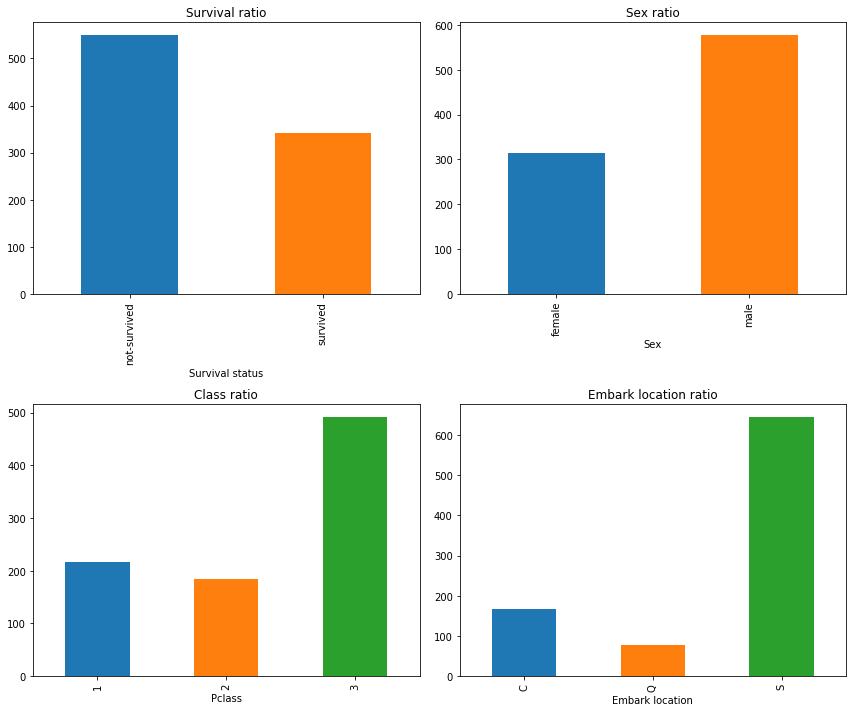

In [7]:
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_figheight(10)
fig.set_figwidth(12)

survive_group = data.groupby(('Survived'))[['Survived']].count()
survive_group.rename(columns={'Survived': 'count'}, inplace=True)

surv_ax = survive_group.unstack().plot.bar(ax=axes[0,0], title='Survival ratio')
surv_ax.set_xlabel('Survival status')
surv_ax.set_xticklabels(['not-survived', 'survived'])

gb_group = data.groupby(('Sex'))[['Sex']].count()
gb_group.rename(columns={'Sex': 'count'}, inplace=True)

sex_ax = gb_group.unstack().plot.bar(ax=axes[0,1], title='Sex ratio')
sex_ax.set_xlabel('Sex')
sex_ax.set_xticklabels(['female', 'male'])

class_group = data.groupby(('Pclass'))[['Pclass']].count()
class_group.columns = ['count']

class_ax = class_group.unstack().plot.bar(ax=axes[1,0], title='Class ratio')
class_ax.set_xlabel('Pclass')
class_ax.set_xticklabels(['1','2','3'])

embark_group = data.groupby(('Embarked'))[['Embarked']].count()
embark_group.columns = ['count']

embark_ax = embark_group.unstack().plot.bar(ax=axes[1,1], title='Embark location ratio')
embark_ax.set_xlabel('Embark location')
embark_ax.set_xticklabels(['C','Q','S'])

plt.tight_layout()
plt.show()

## Numerical distributions

## Variable relationships

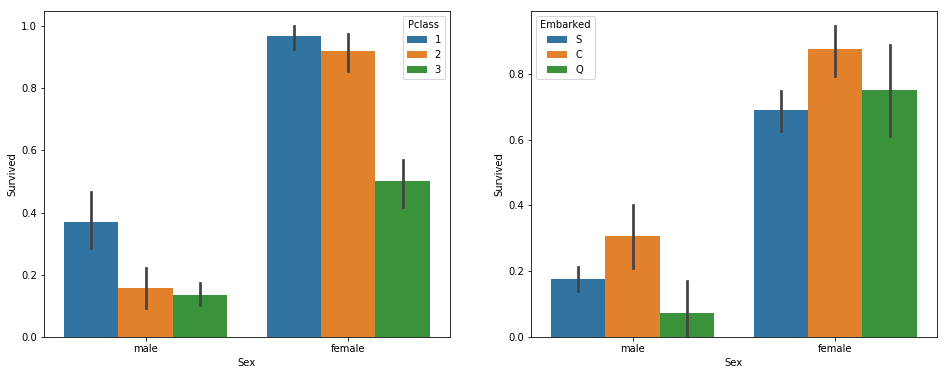

In [8]:
fig, axes = plt.subplots(nrows = 1, ncols = 2)
fig.set_figheight(6)
fig.set_figwidth(16)

sns.barplot(x='Sex', y='Survived', hue='Pclass', data=data, ax=axes[0])

sns.barplot(x='Sex', y='Survived', hue='Embarked', data=data, ax=axes[1])

plt.show()

Sex perceivably is a strong indicator of survival rate compared to other variables.

In [9]:
ss_group = data.groupby(['Sex', 'Survived'])['Sex'].count()
result = stats.chi2_contingency(ss_group.unstack('Survived'))
print('Sex-Survived Chi2\nchi2: {}, p-value: {}'.format(result[0], result[1]))

cs_group = data.groupby(['Pclass', 'Survived'])['Pclass'].count()
result = stats.chi2_contingency(cs_group.unstack('Survived'))
print('Pclass-Survived Chi2\nchi2: {}, p-value: {}'.format(result[0], result[1]))

es_group = data.groupby(['Embarked', 'Survived'])['Embarked'].count()
result = stats.chi2_contingency(es_group.unstack('Survived'))
print('Embarked-Survived Chi2\nchi2: {}, p-value: {}'.format(result[0], result[1]))

Sex-Survived Chi2
chi2: 260.71702016732104, p-value: 1.1973570627755645e-58
Pclass-Survived Chi2
chi2: 102.88898875696056, p-value: 4.549251711298793e-23
Embarked-Survived Chi2
chi2: 26.48914983923762, p-value: 1.769922284120912e-06


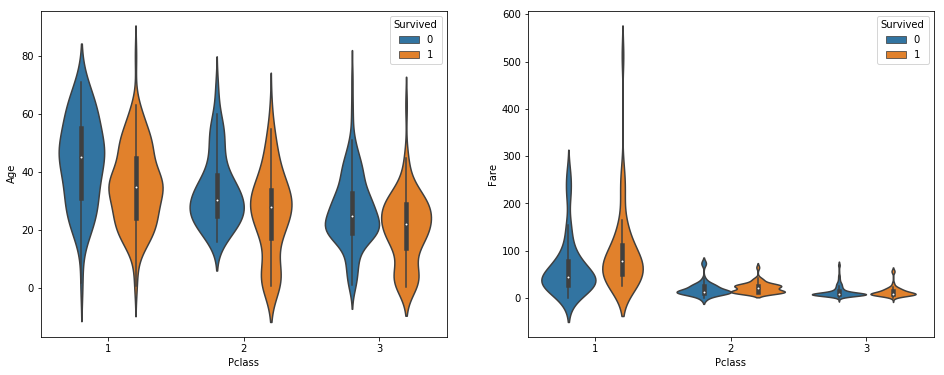

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(6)
fig.set_figwidth(16)

sns.violinplot(x='Pclass', y='Age', hue='Survived', data=data, ax=axes[0])

sns.violinplot(x='Pclass', y='Fare', hue='Survived', data=data, ax=axes[1])

plt.show()

From the left violinplot, it seems that people who survive tend to be younger (lower age).

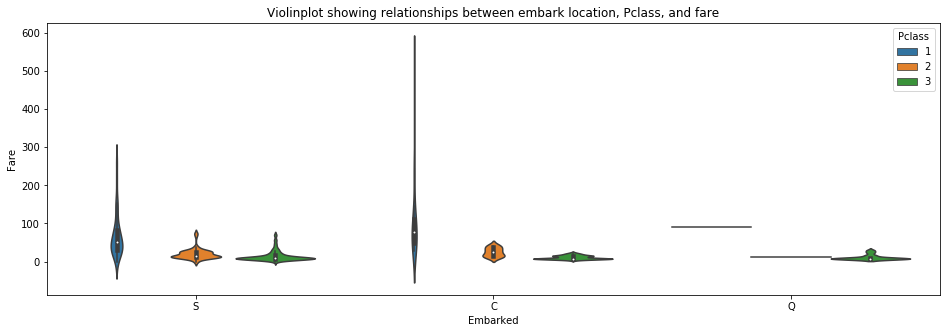

In [11]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(16)

sns.violinplot(x='Embarked', y='Fare', hue='Pclass', data=data)
plt.title('Violinplot showing relationships between embark location, Pclass, and fare')

plt.show()

Another hypothesis that might help us determine the survival rate of each person is that big families may take longer to gather their family members. So, they have lower probability of surviving. As a result we will construct another feature called FamilySize computed by combining the sibling/spouse and parents/children columns together added by 1.

In [12]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

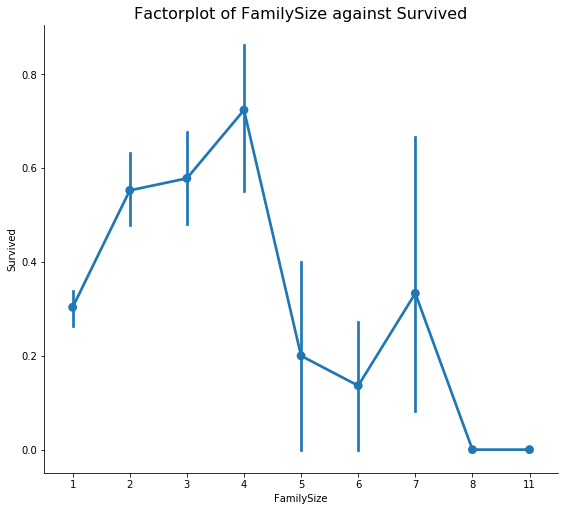

In [13]:
sns.factorplot(x = "FamilySize", y = "Survived", data = data, size = 8)
plt.title("Factorplot of FamilySize against Survived", fontsize = 16)
plt.subplots_adjust(top=0.85)
plt.show()

In [14]:
data['transformed_fare'] = np.log(data['Fare'].divide(data['FamilySize']))
data['transformed_fare'].replace([-np.inf], 0, inplace=True)

/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


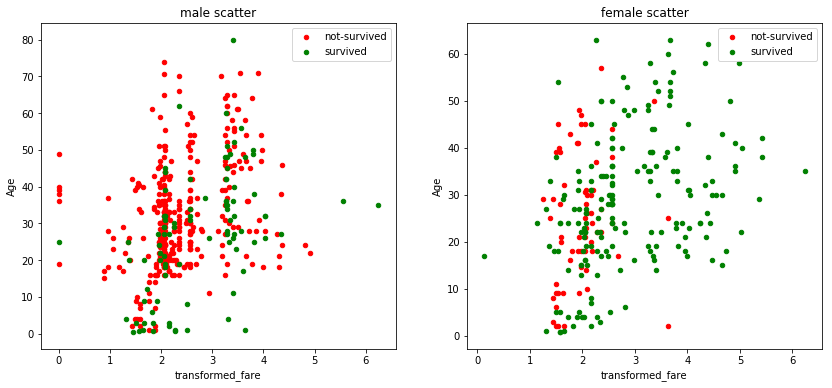

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(6)
fig.set_figwidth(14)

data[np.logical_and(data['Sex'] == 'male', 
                    data['Survived'] == 0)].plot.scatter(x='transformed_fare', y='Age', color='red', title='male scatter',
                                                         label='not-survived', ax=axes[0])
data[np.logical_and(data['Sex'] == 'male', 
                    data['Survived'] == 1)].plot.scatter(x='transformed_fare', y='Age', color='green',
                                                         label='survived', ax=axes[0])

data[np.logical_and(data['Sex'] == 'female', 
                    data['Survived'] == 0)].plot.scatter(x='transformed_fare', y='Age', color='red', title='female scatter',
                                                         label='not-survived', ax=axes[1])
data[np.logical_and(data['Sex'] == 'female', 
                    data['Survived'] == 1)].plot.scatter(x='transformed_fare', y='Age', color='green',
                                                         label='survived', ax=axes[1])

plt.show()

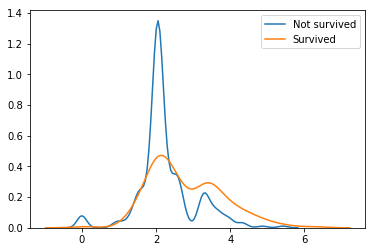

In [16]:
sns.kdeplot(data=data[data['Survived'] == 0]['transformed_fare'])
sns.kdeplot(data=data[data['Survived'] == 1]['transformed_fare'])
plt.legend(['Not survived', 'Survived'])
plt.show()

            Survived    Pclass       Age      Fare  FamilySize
Survived    1.000000 -0.338481 -0.077221  0.257307    0.016639
Pclass     -0.338481  1.000000 -0.369226 -0.549500    0.065997
Age        -0.077221 -0.369226  1.000000  0.096067   -0.301914
Fare        0.257307 -0.549500  0.096067  1.000000    0.217138
FamilySize  0.016639  0.065997 -0.301914  0.217138    1.000000


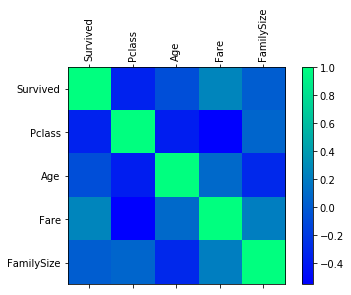

In [17]:
corr_labels = ['Survived', 'Pclass', 'Age', 'Fare', 'FamilySize']
corrs = data.loc[:,corr_labels].corr()
print(corrs)

fig = plt.figure()
ax = fig.add_subplot(111)

cax = ax.matshow(corrs, cmap='winter')
fig.colorbar(cax)
ticks = np.arange(0,5,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corr_labels, rotation=90)
ax.set_yticklabels(corr_labels)
plt.show()

Age variable shows a certain level of correlation with Pclass, SibSp, and Parch variables. Therefore, we'll use these variables as features to train a regressor model to fill the missing values in the age column.

## Data preparation

In [18]:
data['Cabin'].fillna(value='N', inplace=True)
data['Cabin'] = data['Cabin'].str[0]

In [19]:
cabsur_group = data.groupby(('Survived', 'Cabin'))[['Cabin']].count()
print(cabsur_group)

                Cabin
Survived Cabin       
0        A          8
         B         12
         C         24
         D          8
         E          8
         F          5
         G          2
         N        481
         T          1
1        A          7
         B         35
         C         35
         D         25
         E         24
         F          8
         G          2
         N        206


In [20]:
cabin_map = {cabin: i for i, cabin in enumerate(data['Cabin'].value_counts().keys())}
print(cabin_map)

{'N': 0, 'C': 1, 'B': 2, 'D': 3, 'E': 4, 'A': 5, 'F': 6, 'G': 7, 'T': 8}


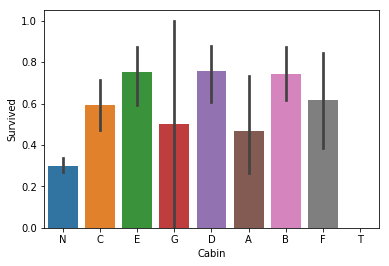

In [21]:
sns.barplot(x='Cabin', y='Survived', data=data)

plt.show()

In [22]:
def categorize_family(fam_size):
    category = ''
    if fam_size == 1:
        category = 'alone'
    elif fam_size <= 4:
        category = 'small'
    else:
        category = 'big'
    return category

def categorize_fare(log_fare):
    category = ''
    if log_fare <= 1.5:
        category = 'low'
    elif log_fare <= 3:
        category = 'average'
    elif log_fare <= 4:
        category = 'high'
    else:
        category = 'very high'
    return category

In [23]:
train_target = data['Survived']

data['HasCabin'] = data['Cabin'].map(lambda x: 'Y' if x != 'N' else 'N')
data['FamilyType'] = data['FamilySize'].map(categorize_family)
data['FareRange'] = data['transformed_fare'].map(categorize_fare)

In [24]:
fare_medians = data.groupby(('Pclass'))['Fare'].median()
print(fare_medians)

Pclass
1    60.2875
2    14.2500
3     8.0500
Name: Fare, dtype: float64


### Train a regression model to fill missing age values

In [25]:
elas_features = data[np.logical_not(data['Age'].isnull())][['Age', 'Pclass', 'transformed_fare', 'SibSp', 'Parch']]
age_labels = elas_features[['Age']]
elas_features = elas_features.iloc[:,1:]

x_elas_train, x_elas_test, y_elas_train, y_elas_test = train_test_split(elas_features, age_labels, test_size=0.2,
                                                                        random_state=1)

print(y_elas_train.head())
print(x_elas_train.head())

      Age
830  15.0
565  24.0
148  36.5
105  28.0
289  22.0
     Pclass  transformed_fare  SibSp  Parch
830       3          1.977838      1      0
565       3          2.085672      2      0
148       2          2.159484      0      2
105       3          2.066331      0      0
289       3          2.047693      0      0


In [26]:
param_grid = {'l1_ratio': np.arange(0, 1.05, 0.05)}
age_regressor = linear_model.ElasticNet()

age_gm = GridSearchCV(age_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')
age_gm.fit(x_elas_train, y_elas_train)

/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'l1_ratio': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [27]:
print(age_gm.best_params_)
print(age_gm.best_score_)

{'l1_ratio': 1.0}
-167.01107606519656


In [28]:
y_elas_pred = age_gm.predict(x_elas_test)
print(metrics.r2_score(y_elas_test, y_elas_pred))
print(metrics.mean_squared_error(y_elas_test, y_elas_pred))

0.1675449953055732
173.23620913588007


In [29]:
def fill_value_by_ml(row, target_col, feature_cols, model):
    features = row[feature_cols]
    if np.isnan(row[target_col]):
        return float(model.predict([features]))
    else:
        return row[target_col]

def categorize_age(age):
    category = ''
    if age <= 1:
        category = 'infant'
    elif age <= 4:
        category = 'toddler'
    elif age <= 13:
        category = 'child'
    elif age <= 18:
        category = 'teenager'
    elif age <= 35:
        category = 'young adult'
    elif age <= 45:
        category = 'adult'
    elif age <= 55:
        category = 'middle aged'
    elif age <= 65:
        category = 'senior citizen'
    else:
        category = 'old'
    return category

In [30]:
data['Age'] = data.apply(fill_value_by_ml, axis=1, target_col='Age',
                         feature_cols=['Pclass', 'Fare', 'SibSp', 'Parch'], model=age_gm)

In [31]:
data['AgeClass'] = data['Age'].map(categorize_age)

In [32]:
cat_labels = ['Sex', 'Embarked', 'FamilyType', 'HasCabin', 'Pclass', 'AgeClass', 'FareRange']
train_data = pd.get_dummies(data, columns=cat_labels)

drop_labels = ['Survived', 'Name', 'SibSp', 'Parch', 'Cabin', 'Age', 'FamilySize', 'Fare', 'transformed_fare']
train_data.drop(columns=drop_labels, inplace=True)

In [33]:
k_fold = 4
test_size = 1/k_fold

## Neural networks

In [34]:
# Experimental parameters
layer_nums = np.arange(2,4)
unit_nums = np.arange(3,11)
param_grid = {'hidden_layer_sizes': list(itertools.product(layer_nums, unit_nums))}

In [35]:
ann = neural_network.MLPClassifier(max_iter=500)

ann_gm = GridSearchCV(ann, param_grid, cv=k_fold, scoring='accuracy', n_jobs=-1)
ann_gm.fit(train_data, train_target)

GridSearchCV(cv=4, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'hidden_layer_sizes': [(2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [36]:
print(ann_gm.best_params_)
print(ann_gm.best_score_)

{'hidden_layer_sizes': (2, 9)}
0.8181818181818182


## Random Forest

In [37]:
# Experimental parameters
depths = np.arange(5,15)
n_estimators = np.arange(50, 351, 50)

param_grid = dict(max_depth=depths, n_estimators=n_estimators)

In [38]:
rand_forest = ensemble.RandomForestClassifier()

forest_gm = GridSearchCV(rand_forest, param_grid, cv=k_fold, scoring='accuracy', n_jobs=-1)
forest_gm.fit(train_data, train_target)

GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [39]:
print(forest_gm.best_params_)
print(forest_gm.best_score_)

{'max_depth': 8, 'n_estimators': 50}
0.8035914702581369


## XGBoost

In [40]:
# Experimental parameters
depths = np.arange(3,8)
n_estimators = np.arange(150, 401, 50)

param_grid = dict(max_depth=depths, n_estimators=n_estimators)

In [41]:
xboost = xgb.XGBClassifier()

xgb_gm = GridSearchCV(xboost, param_grid, cv=k_fold, scoring='accuracy', n_jobs=-1)
xgb_gm.fit(train_data, train_target)

/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151

GridSearchCV(cv=4, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([3, 4, 5, 6, 7]), 'n_estimators': array([150, 200, 250, 300, 350, 400])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [42]:
print(xgb_gm.best_params_)
print(xgb_gm.best_score_)

{'max_depth': 4, 'n_estimators': 150}
0.8215488215488216


# Test

In [43]:
test_df = pd.read_csv('test.csv')

In [44]:
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1
test_df['FamilyType'] = test_df['FamilySize'].map(categorize_family)

test_df['Fare'] = test_df.apply(lambda x: x.loc['Fare'] if not np.isnan(x.loc['Fare']) else fare_medians[x.loc['Pclass']],
                                axis=1)
test_df['transformed_fare'] = np.log(test_df['Fare'].divide(test_df['FamilySize']))
test_df['transformed_fare'].replace([-np.inf], 0, inplace=True)
test_df['FareRange'] = test_df['transformed_fare'].map(categorize_fare)

test_df['Cabin'].fillna(value='N', inplace=True)
test_df['Cabin'] = test_df['Cabin'].str[0]
test_df['HasCabin'] = test_df['Cabin'].apply(lambda x: 'Y' if x != 'N' else 'N')

test_df['Age'] = test_df.apply(fill_value_by_ml, axis=1, target_col='Age',
                               feature_cols=['Pclass', 'transformed_fare', 'SibSp', 'Parch'], model=age_gm)
test_df['AgeClass'] = test_df['Age'].map(categorize_age)

/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [45]:
test_data = pd.get_dummies(test_df, columns=cat_labels)
test_data.drop(columns=['PassengerId', 'Ticket'], inplace=True)
test_data.drop(columns=drop_labels[1:], inplace=True)

In [46]:
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 26 columns):
Sex_female                 418 non-null uint8
Sex_male                   418 non-null uint8
Embarked_C                 418 non-null uint8
Embarked_Q                 418 non-null uint8
Embarked_S                 418 non-null uint8
FamilyType_alone           418 non-null uint8
FamilyType_big             418 non-null uint8
FamilyType_small           418 non-null uint8
HasCabin_N                 418 non-null uint8
HasCabin_Y                 418 non-null uint8
Pclass_1                   418 non-null uint8
Pclass_2                   418 non-null uint8
Pclass_3                   418 non-null uint8
AgeClass_adult             418 non-null uint8
AgeClass_child             418 non-null uint8
AgeClass_infant            418 non-null uint8
AgeClass_middle aged       418 non-null uint8
AgeClass_old               418 non-null uint8
AgeClass_senior citizen    418 non-null uint8
AgeClass_teenager    

In [47]:
print(train_data.shape)
print(test_data.shape)

(891, 26)
(418, 26)


## Neural networks

In [44]:
test_pred = ann_gm.predict(test_data)

/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Random Forest

In [54]:
test_pred = forest_gm.predict(test_data)

## XGBoost

In [48]:
test_pred = xgb_gm.predict(test_data)

/Users/chanuwasaswamenakul/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Saving predictions

In [49]:
output_df = pd.DataFrame(test_df['PassengerId'])
output_df['Survived'] = test_pred
output_df.to_csv('titanic_submission.csv', index=False)